In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_price_df(day) -> pd.DataFrame:
    file_name = f"prices_round_4_day_{day}.csv"
    df = pd.read_csv(file_name, sep=';')
    return df

def get_obs_df(day) -> pd.DataFrame:
    file_name = f"observations_round_4_day_{day}.csv"
    df = pd.read_csv(file_name, sep=',')
    return df

def get_product(df: pd.DataFrame, product: str) -> pd.DataFrame:
    return df[df['product'] == product].copy()

In [3]:
DAYS = range(1, 4)
underlying = "MAGNIFICENT_MACARONS"

price_rows = []
obs_rows = []

for day in DAYS:
    
    prices = get_price_df(day)
    obs = get_obs_df(day)
    obs['day'] = day
    macaron = get_product(prices, underlying)

    price_rows.append(macaron)
    obs_rows.append(obs)

    

obs_df = pd.concat(obs_rows, ignore_index=True)
macaron_df = pd.concat(price_rows, ignore_index=True)

In [4]:
macaron_df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,MAGNIFICENT_MACARONS,624.0,20.0,622.0,12.0,617.0,23.0,631,10,639.0,23.0,644.0,12.0,627.5,0.0
1,1,100,MAGNIFICENT_MACARONS,627.0,14.0,625.0,12.0,620.0,21.0,634,7,642.0,21.0,647.0,12.0,630.5,0.0
2,1,200,MAGNIFICENT_MACARONS,627.0,10.0,625.0,15.0,620.0,21.0,634,5,642.0,21.0,647.0,15.0,630.5,0.0
3,1,300,MAGNIFICENT_MACARONS,629.0,14.0,627.0,14.0,622.0,26.0,636,7,644.0,26.0,649.0,14.0,632.5,0.0
4,1,400,MAGNIFICENT_MACARONS,628.0,18.0,625.0,16.0,620.0,26.0,635,9,643.0,26.0,648.0,16.0,631.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,3,999500,MAGNIFICENT_MACARONS,794.0,12.0,792.0,16.0,786.0,22.0,802,6,811.0,22.0,817.0,16.0,798.0,0.0
29996,3,999600,MAGNIFICENT_MACARONS,798.0,10.0,796.0,13.0,790.0,29.0,806,5,815.0,29.0,821.0,13.0,802.0,0.0
29997,3,999700,MAGNIFICENT_MACARONS,801.0,20.0,798.0,16.0,792.0,20.0,809,10,817.0,20.0,823.0,16.0,805.0,0.0
29998,3,999800,MAGNIFICENT_MACARONS,795.0,14.0,793.0,13.0,787.0,22.0,803,7,812.0,22.0,818.0,13.0,799.0,0.0


In [5]:
obs_df

,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex,day
0,0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00,1
1,100,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00,1
2,200,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00,1
3,300,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01,1
4,400,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01,1
...,...,...,...,...,...,...,...,...,...
29995,999500,797.5,799.0,1.7,9.5,-5.5,212.124918,54.95,3
29996,999600,801.5,803.0,1.7,9.5,-5.5,212.147650,54.96,3
29997,999700,804.0,805.5,1.7,9.5,-5.5,212.202086,54.97,3
29998,999800,798.5,800.0,1.7,9.5,-5.5,212.112734,54.98,3


In [7]:
def plot_macaron_signals(macaron_df, obs_df, initial_threshold, alpha, ts_per_day=1_000_000):
    """
    Plot MACARON mid_price on the primiary y-axis,
    sunlightIndex on the secondary y-axis.
    Mark buy signals when sunlightIndex crosses below 'threshold'
    and sell signals when sunlightIndex starts rising after being below.

    Parameters
    -----------------
    macaron_df : pd.DataFrame
        Must contain ['day', 'timestamp', 'mid_price'].
    obs_df : pd.DataFrame
        Must contain ['day', 'timestamp', 'sunlightIndex']
    threshold : float
        sunlightIndex threshold for buy signals.
    ts_per_day : int
        The number to multiply each day by, to offset timestamp.
        (e.g. if each day's timestamps go from 0-999900, use 1_000_000)
        """
    df = (
    macaron_df[['day', 'timestamp', 'mid_price']]
    .merge(obs_df[['day', 'timestamp','sunlightIndex']],
    on=['day', 'timestamp'], how='inner')
    .sort_values(['day', 'timestamp'])
    )

    df['time'] = df['day'] * ts_per_day + df['timestamp']

    thr = [initial_threshold]
    suns = df['sunlightIndex'].values
    for i in range(1, len(suns)):
        thr.append((1- alpha) * thr[i-1] + alpha * suns[i])
    df['threshold_ema'] = thr
    df['thr_prev'] = df['threshold_ema'].shift(1)

    df['sun_prev'] = df['sunlightIndex'].shift(1)
    df['raw_buy'] = (df['sun_prev'] >= df['thr_prev']) & (df['sunlightIndex'] < df['threshold_ema'])
    df['raw_sell'] = (df['sun_prev'] < df['threshold_ema']) & ((df['sunlightIndex'] - df['sun_prev']) > 0)

    last_signal = None
    buys, sells = [], []
    for idx, row in df.iterrows():
        if row['raw_buy'] and last_signal != 'buy':
            buys.append(idx)
            last_signal = 'buy'
        elif row['raw_sell'] and last_signal != 'sell':
            sells.append(idx)
            last_signal = 'sell'

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(df['time'], df['mid_price'], color='silver', label='Macaron Mid Price')

    ax1.scatter(df.loc[buys, 'time'], df.loc[buys, 'mid_price'],
                marker='^', s=100, facecolors='green', edgecolors='none', label='Buy')
    ax1.scatter(df.loc[buys, 'time'], df.loc[buys, 'mid_price'],
                s=300, facecolors='none', edgecolors='green', linewidths=1.5)

    ax1.scatter(df.loc[sells, 'time'], df.loc[sells, 'mid_price'],
                marker='v', s=100, facecolors='red', edgecolors='none', label='Sell')
    ax1.scatter(df.loc[sells, 'time'], df.loc[sells, 'mid_price'],
                s=300, facecolors='none', edgecolors='red', linewidths=1.5)

    ax1.set_xlabel('Time (day * offset + timestamp)')
    ax1.set_ylabel('Macaron Mid Price')

    ax2 = ax1.twinx()
    ax2.plot(df['time'], df['sunlightIndex'], color='gold', linestyle='--', label='Sunlight Index')
    ax2.plot(df['time'], df['threshold_ema'], color='orange', linestyle='-.', label='EMA Threshold')
    ax2.set_ylabel('Sunlight / EMA Threshold')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='best')

    plt.title(f'Macaron Signals with EMA Threshold (alpha={alpha}, init={initial_threshold})')
    plt.tight_layout()
    plt.show()

    

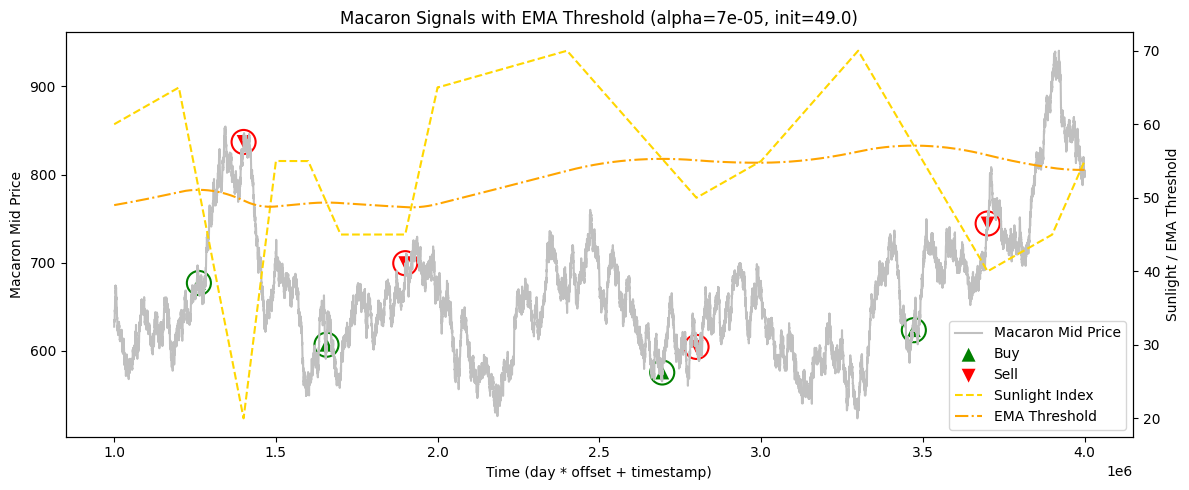

In [52]:
plot_macaron_signals(macaron_df, obs_df, initial_threshold=49.0, alpha=0.00007, ts_per_day=1_000_000)

## This was all pointless....

* Turns out IMC decided to have a bot trade at a fixed price of (foreign ask - 1.5) or something with close to 100% certainty....